# Running an Applet on Bulk files

## An application on the OxWearables stepcount tool

The UK Biobank provides access to various types of bulk data at the **individual** level, including imaging, genetic, and wearable sensor data. Analysing these large-scale datasets can be both time-consuming and computationally intensive. In this tutorial, we present examples of how to run an applet on bulk files, specifically accelerometry data, using the [stepcount](https://github.com/OxWearables/stepcount) tool developed by OxWearables.

Oxwearables have also developed a DNAnexus applet that runs on the UK Biobank Research Analysis Platform. It processes accelerometry files, e.g. [field id 90001](https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=90001https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=90001), and provides detailed information on steps, walking patterns, cadence, and more. Additional information is available on [OxWearables' GitHub](https://github.com/OxWearables/dnanexus-stepcounthttps://github.com/OxWearables/dnanexus-stepcount)

The applet processes one file at a time, corresponding to one participant; the accelerometry files being at the individual level. The running time of the applet for a single accelerometry file depends on the size of the file, and can from 2 minutes to 20 minutes. The estimated cost is approximately £0.005 per file, and around £5 for 1,000 files. 

If you are interested in running the tool on multiple bulk files, there are different strategies you can follow. The following notebook present some useful examples on how the tool can be run on multiple files. 

The figure below summarises the structure of the Self-supervised learning model used to build the stepcount tool. 


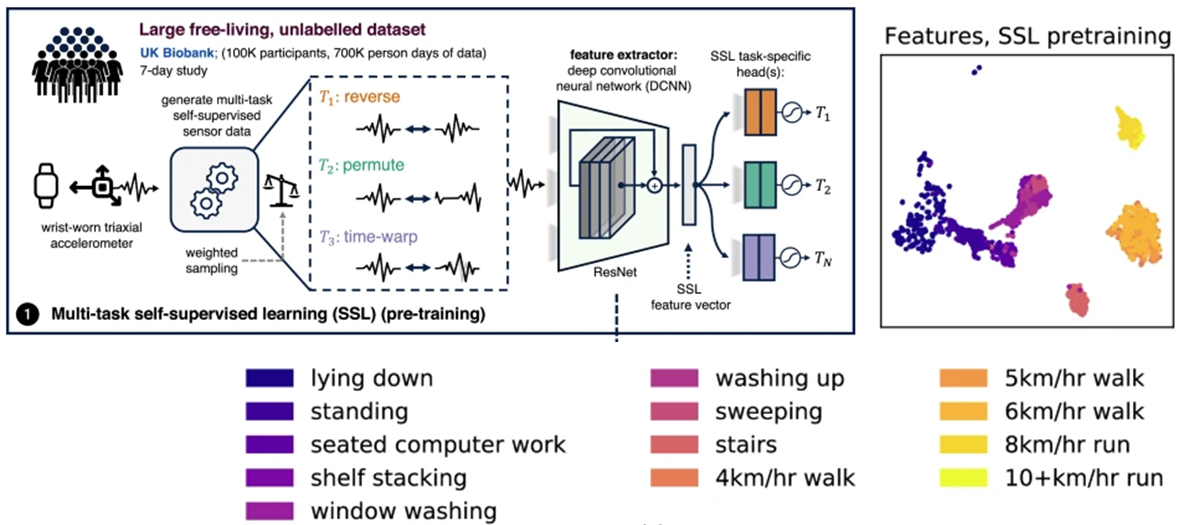

## Running the stepcount tool on Multiple Files

### Pre-requisites

This notebook uses a **bash** kernel. You can select change the kernel by navigating to the top right-hand corner of the notebook and click on the current kernel.

#### Running the applet - Strategy 1

Before going through this guide, you need to have built the stepcount applet available in the [stepcount-dnanexus](https://github.com/OxWearables/dnanexus-stepcount) GitHub repository.
The **[ReadMe](https://github.com/OxWearables/dnanexus-stepcount/blob/main/README.md)** provides useful instructions on building the applet. 

#### Using the docker image - Strategy 2

The stepcount tool can also be run by building a **docker image** and using it within Swiss Army Knife. 

You can find the `build_docker_image.ipynb` notebook and a `step-count.dockerfile`,  which guide you through either building the Docker image locally or pulling a pre-built image. You will then upload the image to your RAP project. The `build_docker_image.ipynb` notebook can be run either locally or on the RAP in Jupyter Lab instance, but you need to ensure that you have docker and the dx-toolkit installed. 

Please note that RAP allows for overlapping file names, so make sure that you have a unique file names before running a tool to avoid errors.

### **Note:**
If you are working on Windows, text files may contain different line endings than those used on Unix-based systems. This can introduce hidden characters and produce an error when running applets.

To avoid this issue, convert your text files using *dos2unix* before uploading. This tool is available through Anaconda and other sources.


### Step 1: Create a list of files to run the applet on

If you are interested in field 90001, retrieve all participants with data for this field:

In [ ]:
# Extract all files corresponding to field id 90001 
dx find data --property field_id=90001 > acc_files.txt


The **--brief** argument is useful to extract only file-IDs. You can find additional documentation [here](https://documentation.dnanexus.com/user/helpstrings-of-sdk-command-line-utilities#find-data). You can run the following command:

`dx find data --property field_id=90001 --brief > acc-file-ids.txt`

*Note: If you are interested in selecting specific participants, the file names include the participants eids. You can filter them from acc_files.txt*

The following command extracts the file ID and the file name. Please note that the path is file specific and you might want to modify it for files in a different folder. 

In [ ]:
# Extract File-IDs and names from the list of files

awk '
{
  if ($0 ~ /(file-[A-Za-z0-9]+)/) {
    match($0, /(file-[A-Za-z0-9]+)/)
    id = substr($0, RSTART, RLENGTH)
  }
  if ($0 ~ /\/Bulk\/Activity\/Raw\/[^ ]+\/([^ ]+\.cwa)/) {
    match($0, /\/Bulk\/Activity\/Raw\/[^ ]+\/[^ ]+\.cwa/)
    fname = substr($0, RSTART, RLENGTH)
    split(fname, parts, "/")
    print id "\t" parts[length(parts)]
  }
}' acc_files.txt > output.txt


For the purpose of this example, we randomly select 80 files. You can provide a list of specific eids you are interest in and filter them from *output.txt*. 

In [ ]:
shuf -n 80 output.txt > random_80_files.txt

The strategies below demonstrates the use of applets and Swiss Army Knife which are tools provided by DNA Nexus. These tools can be executed via the command line using the provided commands below or interactively, through the DNANexus [tools library](https://ukbiobank.dnanexus.com/panx/tools). 

### Step 2: Run stepcount on multiple files

#### **Strategy 1:** Run multiple applet instances in parallel

- Run the dnanexus-stepcount applet on individual files by launching **multiple applet instances in parallel**.

- The cost is really - low <0.005 on average per instance.

After having selected the files of interest in the first step, you have to upload the file, here *random_80_files.txt*, to your project. Please note that the applet and the file should be in the same folder location, otherwise you will have to provide the path to the file.
This notebook runs in a different environment then the environment the applet will run in. As the applet is built from your project, the input file needs to be within your project too. 

You can upload your file using the dx command **dx upload**



In [ ]:
dx upload random_80_files.txt

After uploading your file to your RAP project, you can use the [xargs](https://pubs.opengroup.org/onlinepubs/009604599/utilities/xargs.html) utility to launch the instances in parallel. 
The applet takes as input the file-ID of the accelerometry files, so the first column was selected.

Please specify the path to folder you want to save the applet's outputs. 

In [ ]:
cat random_80_files.txt  |  awk '{print $1}'  | xargs -I {} dx run stepcount -iinput_file={} --destination="$DX_PROJECT_CONTEXT_ID/Path/to/your/folder/"

You should expect the following folder structure in the **output** folder created in the path you provided: 

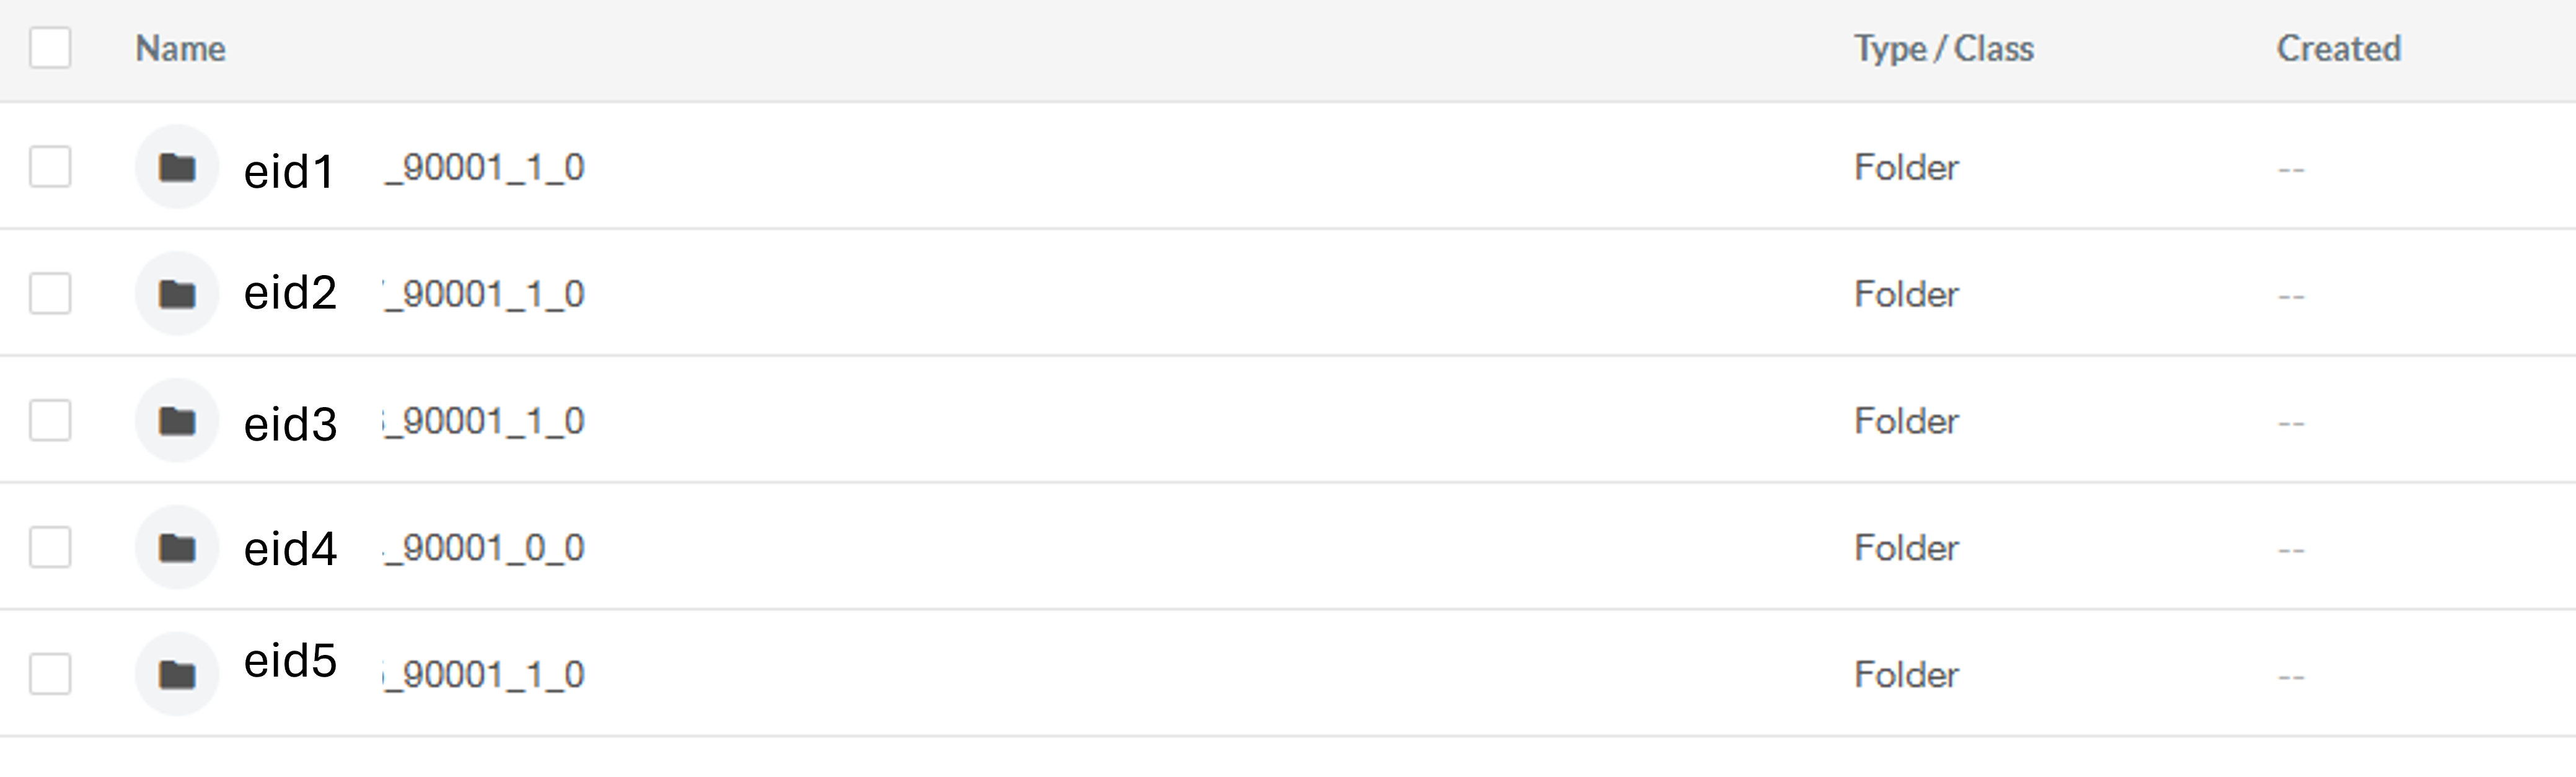

Each folder <eid>_<field_id>_<ins_index>_<arr_index> will include the following derived files for a single participant from the corresponding individual accelerometry file:

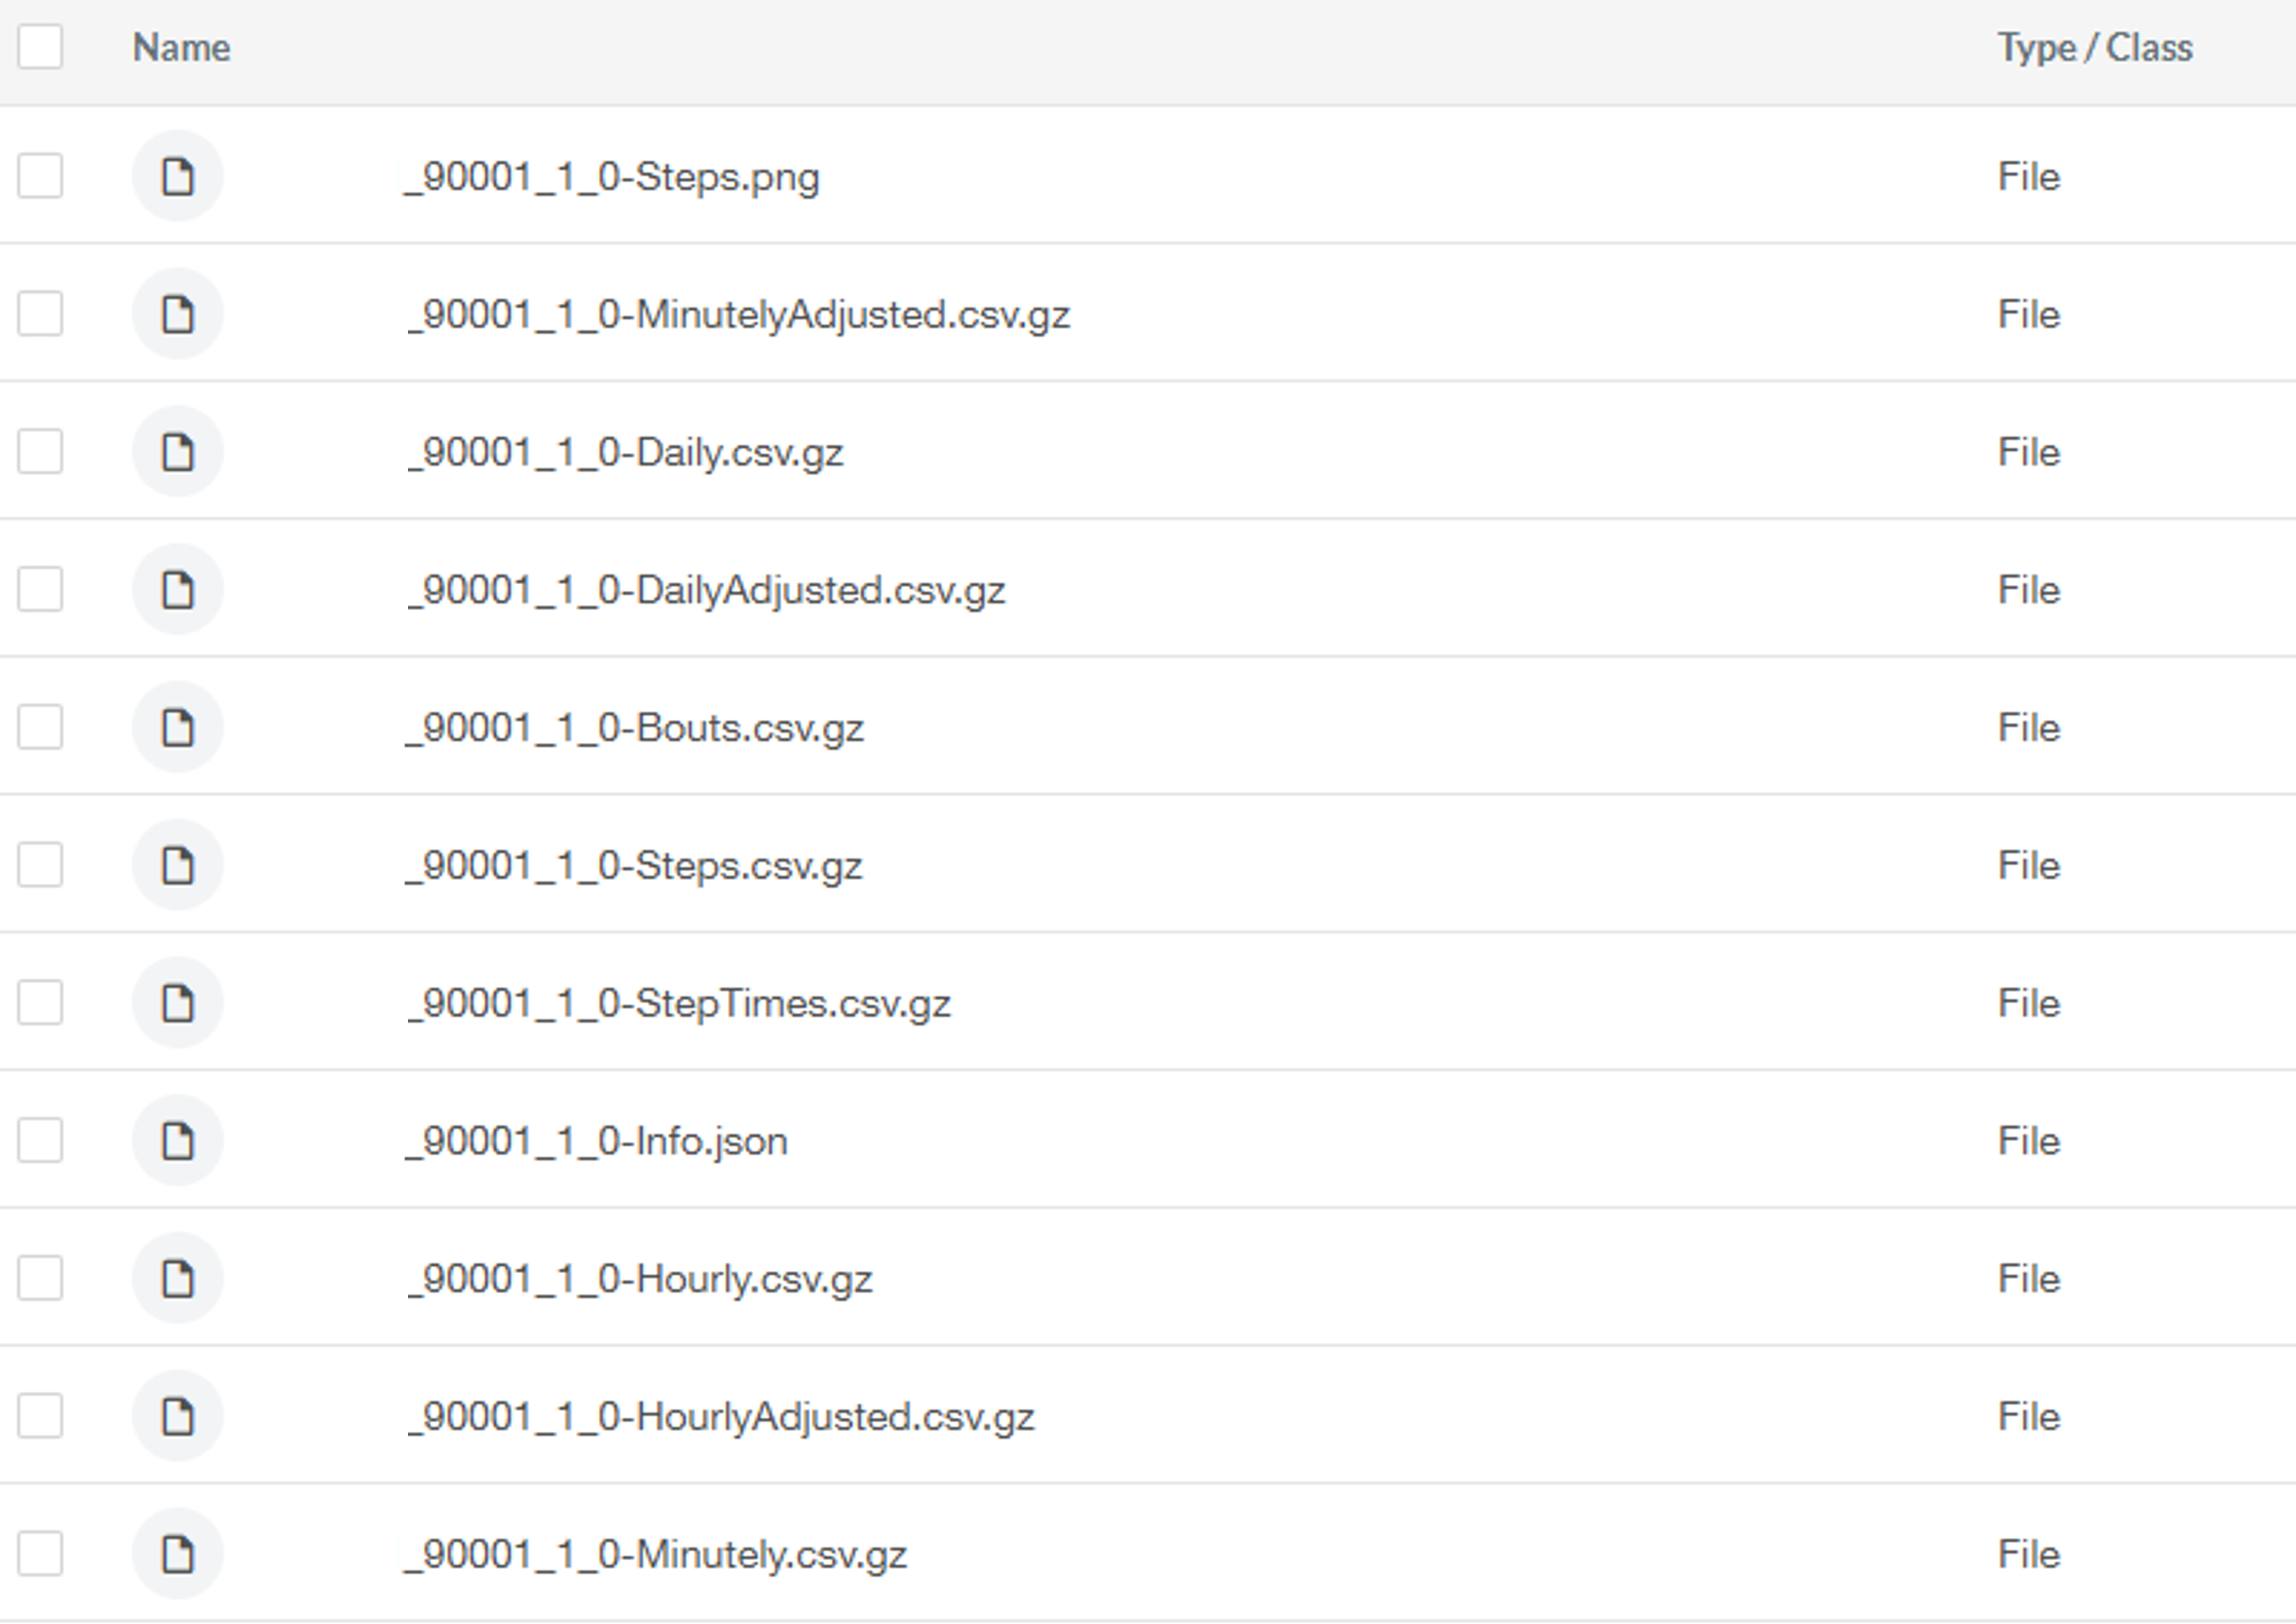

#### **Strategy 2:** Running Swiss Army Knife (SAK) on a docker image.

Alternatively, if you have a [docker image](https://platform.dnanexus.com/panx/tool/app/swiss-army-knife) saved in your project space, you can utilise the [Swiss Army Knife (SAK)](https://platform.dnanexus.com/panx/tool/app/swiss-army-knife) tool that is available from the DNAnexus Tool Library.

This can be launched from a command line interface with the DX toolkit installed on your local computer or a small orchestration instance that runs this script. 

In [ ]:

while IFS=$'\t' read -r file_id filename; do
    dx run swiss-army-knife -icmd="stepcount $filename" -iin="$file_id" -iimage_file="stepcount.tar.gz" --priority low
done < random_80_files.txt


The `build_docker_image.ipynb` notebook that comes in the same folder of this code describes how to pull the docker image referenced above, and how to save this to your DNAnexus project space.

#### **Strategy 3:** Batch processing on modified applet

**N.B:** The first 2 strategies are efficient in terms of cost and time. However, they both involve creating multiple instances, one for each file. The following strategy reduces the number of instances created by modifying the intial stepcount applet.


This method involves modifying the initial stepcount applet. It will take as input a file listing multiple file-IDs corresponding to the individual-level accelerometry files and running the stepcount tool on the individual listed files in parallel.

The modified applet can be found in this repository: **stepcount_multiplefiles**. The applet can be built similarily to the main stepcount applet, by following the same steps and building the asset. 

You will only have to put the folder stepcount_multiplefiles in the same location as the initial applet and run 

`dx build stepcount_multiplefiles`


This approach needs high storage and compute for over 20 files and therefore it is recommended to run it on batches of files. The advantage of this method is that it reduces the amount of instances to launch, although it takes longer time than processing them individually. Depending on the size of files you selected, you might require a bigger instance.


In [ ]:
# Extract the file-IDs only from the file list to match input for applet
cat random_80_files.txt  |  awk '{print $1}' > random_80_files_IDs.txt

The first step involves splitting the list of files into smaller batches of 20 files each.

In [ ]:
input_file="random_80_files_IDs.txt" # This is the input file listing all files of interest
batch_base_name="random_80_files" # This is the prefix for the batches of files created
split -l 20 "$input_file" "$batch_base_name"_ --additional-suffix=.txt

Then you need to create a file that stores the names of the batch files.

In [ ]:
echo ${batch_base_name}_*.txt | tr ' ' '\n' > file_batch_list.txt

Similar to earlier, you have to upload the batch files onto your project space using **dx upload**.

In [ ]:
for batch_file in ${batch_base_name}_*.txt; do
    dx upload "$batch_file"
done

Finally, you run the modified applet in parallel on the batches of files.

In [ ]:
cat file_batch_list.txt | xargs -I "{}" -P 4 dx run stepcount_multiplefiles -iinput_file={} --destination="${DX_PROJECT_CONTEXT_ID}/Path/to/your/folder" --priority high --instance-type mem1_hdd1_v2_x36

To increase speed, you can increase the instance type. However, this might incur higher costs. 